<a href="https://colab.research.google.com/github/enviroCar/notebooks/blob/main/enviroCar_track_acceleration_values_animation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas pandas
!pip install --no-deps envirocar-py 

# set an output directory for the animation and chart:
root_dir = '/content/'

%load_ext autoreload
%autoreload 2

# load dependencies
import pandas as pd
import geopandas as gpd

from envirocar import TrackAPI, DownloadClient, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

     |████████████████████████████████| 1.0 MB 4.9 MB/s 
     |████████████████████████████████| 15.4 MB 51.1 MB/s 
     |████████████████████████████████| 6.3 MB 51.9 MB/s 
  Created wheel for envirocar-py: filename=envirocar_py-0.0.3-py3-none-any.whl size=7404 sha256=c01bf2d67510b21c24a359587b896c82f76e7cd833a81dec421774d36e1c8768
  Stored in directory: /root/.cache/pip/wheels/36/95/27/fe998c23af5c471465b42f98644968ad806aa34b41d3092afb
Successfully built envirocar-py


In [ ]:
# import datetime to help define sample period:
import datetime as dt
# import pandas for data wrangling:
import pandas as pd
# import matplotlib, pyplot and animation for plotting and animating:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# define the animation embed limit for matplotlib:
matplotlib.rcParams['animation.embed_limit'] = 200**128

In [ ]:
track_filter_start = "2021-12-12T11:28:30Z"
track_filter_end = "2021-12-12T11:50:Z"
track_id = "61b5e0887b277d59bd0b2c8c"
track_df = track_api.get_tracks(time_interval=(track_filter_start, track_filter_end))

In [ ]:
print(len(track_df))
df_excerpt = track_df[track_df["track.id"].map(lambda x: x == track_id)]

# remove head and tail as they are unprecise
print(len(df_excerpt))
df_excerpt = df_excerpt.head(len(df_excerpt) - 3)
print(len(df_excerpt))
df_excerpt = df_excerpt.tail(len(df_excerpt) - 3)
print(len(df_excerpt))


1266
77
74
71


In [ ]:
min_phenom = "Minimum GPS Acceleration.value"
max_phenom = "Maximum GPS Acceleration.value"

In [ ]:
import datetime
from dateutil import parser
df = df_excerpt

# parse the time and use as index
df['time_index'] = pd.to_datetime(df['time'])
df = df.set_index('time_index')

# only select phenomena of interest
df = df[['time', max_phenom, min_phenom, 'Maximum Acceleration.value', 'Minimum Acceleration.value']]

# resample to 1 second for better animation
df = df.resample('s').fillna("ffill")

df = df.head(40)

df

,time,Maximum GPS Acceleration.value,Minimum GPS Acceleration.value,Maximum Acceleration.value,Minimum Acceleration.value
time_index,,,,,
2021-12-12 11:36:39+00:00,2021-12-12T11:36:39+00:00,2.670683,0.234694,NaN,NaN
2021-12-12 11:36:40+00:00,2021-12-12T11:36:39+00:00,2.670683,0.234694,NaN,NaN
2021-12-12 11:36:41+00:00,2021-12-12T11:36:39+00:00,2.670683,0.234694,NaN,NaN
2021-12-12 11:36:42+00:00,2021-12-12T11:36:39+00:00,2.670683,0.234694,NaN,NaN
2021-12-12 11:36:43+00:00,2021-12-12T11:36:39+00:00,2.670683,0.234694,NaN,NaN
2021-12-12 11:36:44+00:00,2021-12-12T11:36:44+00:00,1.242830,0.488565,0.946285,0.946285
2021-12-12 11:36:45+00:00,2021-12-12T11:36:44+00:00,1.242830,0.488565,0.946285,0.946285
2021-12-12 11:36:46+00:00,2021-12-12T11:36:44+00:00,1.242830,0.488565,0.946285,0.946285
2021-12-12 11:36:47+00:00,2021-12-12T11:36:44+00:00,1.242830,0.488565,0.946285,0.946285


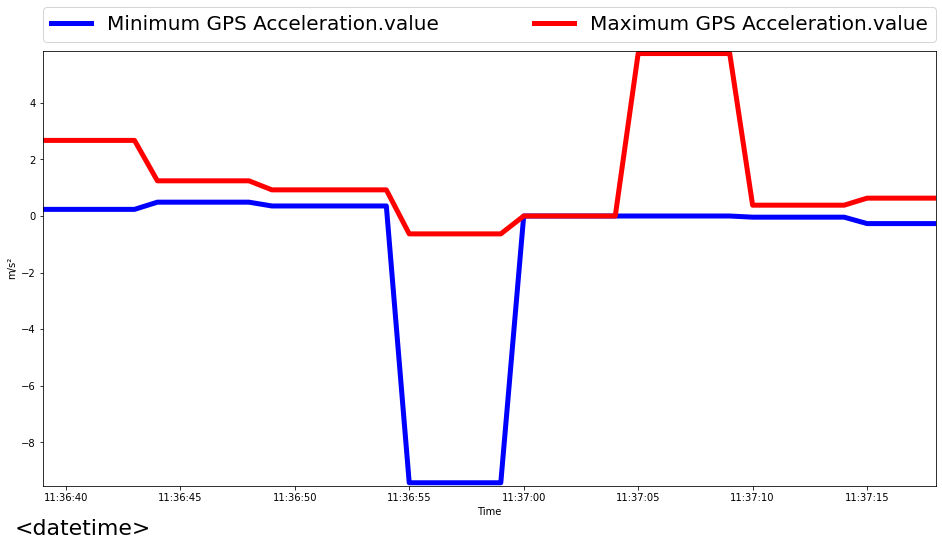

In [ ]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(16,8))

# bounds
ax.set_xlim(df.index[0],df.index[-1])
ax.set_ylim(df[min_phenom].min()-0.1, df[max_phenom].max()+0.1)

min_line, = ax.plot(df[min_phenom], data= df, marker='', color='blue', linewidth=5)
max_line, = ax.plot(df[max_phenom], data= df, marker='', color='red', linewidth=5)

# set the x-axis label:
plt.xlabel('Time',fontsize=10)

# set the y-axis label:
plt.ylabel('m/s²',fontsize=10)

# add a legend to the plot:
#plt.legend()
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
                      ncol=2, mode="expand", borderaxespad=0., prop={"size":20})

text = fig.text(0.10, 0.05, "<datetime>",
        horizontalalignment='left',
        verticalalignment='center', fontsize=22, color='black')

# show the chart:
plt.show();

In [ ]:
def init_animation():
    min_line.set_data([], [])
    max_line.set_data([], [])
    return (min_line, max_line, )


In [ ]:
import numpy as np
# define the function animate, which has the input argument of i:
def animate(i):
    # update the current timestamp
    text.set_text(df["time"].iloc[i])

    # select data up to current index and previous 20 frames
    data =  df.iloc[max(0, int(i-20)):int(i+1)]

    ax.set_xlim(data.index[0],data.index[-1])
    #   initialise xp as an empty list:
    xp = data.index
    y1 = data[min_phenom]
    y2 = data[max_phenom]
    min_line.set_data(xp, y1)
    max_line.set_data(xp, y2)
        
    return (min_line, max_line, )
  

In [ ]:
# calculate fps
# import dateutil
# total_mesaurements = len(df)
# print(total_mesaurements)
# s = df['time'].iat[0]
# e = df['time'].iat[-1]
# length_s = e-s
# fps = length_s.seconds / total_mesaurements
fps = 1
fps

1

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')
# call Matplotlib animation.Funcanimation, providing the input arguments of fig, animate, the number of frames and an interval:
interval_ms = int(fps * 1000)
ani = animation.FuncAnimation(fig, animate, init_func=init_animation, frames = len(df), interval=interval_ms)
ani



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical left == right == 738136.4837847222 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Use the 'ffmpeg' writer:
Writer = animation.writers['ffmpeg']

# Set the frames per second and bitrate of the video:
writer = Writer(fps=1/interval_ms*1000, metadata=dict(artist='Me'), bitrate=1800)
# save the animation to the predefined output directory:
ani.save(root_dir +'animation_video_ffill.mp4', writer=writer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical left == right == 738136.4837847222 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.
